# Levy

# Imports

In [20]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from botorch.test_functions.synthetic import Hartmann
from botorch.test_functions.synthetic import Levy

from baybe import Campaign
from baybe.objective import Objective
from baybe.parameters import NumericalDiscreteParameter, TaskParameter
from baybe.searchspace import SearchSpace
from baybe.simulation import simulate_scenarios
from baybe.targets import NumericalTarget
from baybe.utils.botorch_wrapper import botorch_function_wrapper
from baybe.utils.plotting import create_example_plots

In [13]:
DIMENSION = 3  # input dimensionality of the test function
BATCH_SIZE = 1  # batch size of recommendations per DOE iteration
N_MC_ITERATIONS = 50  # number of Monte Carlo runs
N_DOE_ITERATIONS = 15  # number of DOE iterations
POINTS_PER_DIM = 5  # number of grid points per input dimension

In [15]:
objective = Objective(
    mode="SINGLE", targets=[NumericalTarget(name="Target", mode="MIN")]
)

#BOUNDS = Hartmann(dim=DIMENSION).bounds
BOUNDS = Levy(dim=DIMENSION).bounds

discrete_params = [
    NumericalDiscreteParameter(
        name=f"x{d}",
        values=np.linspace(lower, upper, POINTS_PER_DIM),
    )
    for d, (lower, upper) in enumerate(BOUNDS.T)
]

task_param = TaskParameter(
    name="Function",
    values=["Target", "Source"],
    active_values=["Target"],
)

parameters = [*discrete_params, task_param]
searchspace = SearchSpace.from_product(parameters=parameters)

def shifted_hartmann(*x: float) -> float:
    """Calculate a shifted, scaled and noisy variant of the Hartman function."""
    hartmann = Hartmann(dim=DIMENSION)
    return 2.5 * botorch_function_wrapper(hartmann)(x) + 3.25


test_functions = {
    # "Test_Function": botorch_function_wrapper(Hartmann(dim=DIMENSION)),
    "Target": botorch_function_wrapper(Levy(dim=DIMENSION)),
    # "Training_Function": botorch_function_wrapper(Hartmann(dim=DIMENSION, negate=True))
    # "Training_Function": shifted_hartmann
    "Source": botorch_function_wrapper(Levy(dim=DIMENSION, negate=True, noise_std=0.2))
}

grid = np.meshgrid(*[p.values for p in discrete_params])

lookups = {}
for function_name, function in test_functions.items():
    lookup = pd.DataFrame({f"x{d}": grid_d.ravel() for d, grid_d in enumerate(grid)})
    lookup["Target"] = lookup.apply(function, axis=1)
    lookup["Function"] = function_name
    lookups[function_name] = lookup
lookup_training_task = lookups["Source"]
lookup_test_task = lookups["Target"]

In [16]:
import warnings
warnings.filterwarnings("ignore")

results: list[pd.DataFrame] = []
for p in (0.01, 0.02, 0.05, 0.08, 0.2):
    campaign = Campaign(searchspace=searchspace, objective=objective)
    initial_data = [lookup_training_task.sample(frac=p) for _ in range(N_MC_ITERATIONS)]
    result_fraction = simulate_scenarios(
        {f"TL_{int(100 * p)}": campaign},
        lookup_test_task,
        initial_data=initial_data,
        batch_size=BATCH_SIZE,
        n_doe_iterations=N_DOE_ITERATIONS,
    )
    results.append(result_fraction)

result_baseline = simulate_scenarios(
    {"Baseline": Campaign(searchspace=searchspace, objective=objective)},
    lookup_test_task,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)
results = pd.concat([result_baseline, *results])

100%|#############################################################################################################################################################################| 50/50 [00:51<00:00,  1.03s/it]


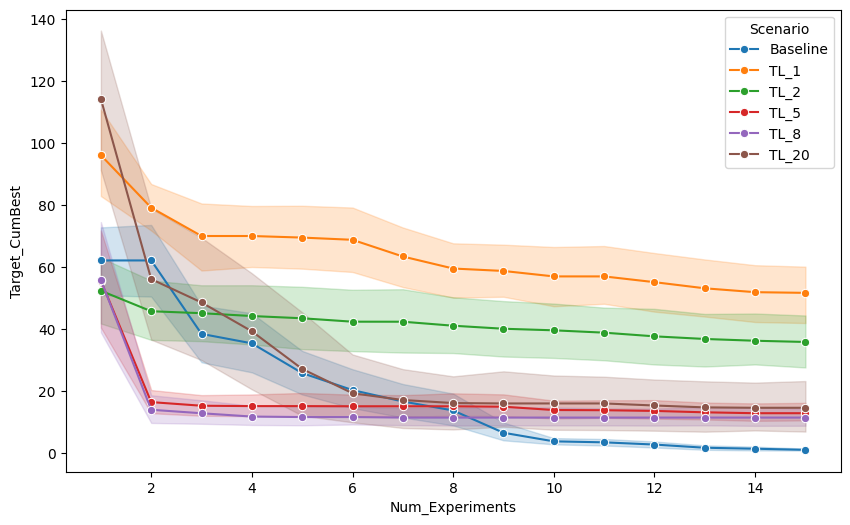

In [23]:
#results.rename(columns={"Scenario": "% of data used"}, inplace=True)

path = Path(sys.path[0])
ax = sns.lineplot(
    data=results,
    marker="o",
    markersize=6,
    x="Num_Experiments",
    y="Target_CumBest",
    hue="Scenario",
)
plt.gcf().set_size_inches((10,6))
plt.show()

# create_example_plots(
#     ax=ax,
#     path=path,
#     base_name="levy_transfer_learning",
# )